# Segmentacion de clúster por el método de k-medias

In [94]:
# ----- IMPORTACION DE LIBRERIAS -----
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import metrics
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from canny import cargarFoto
from otsu import umbralizacionOtsu
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 



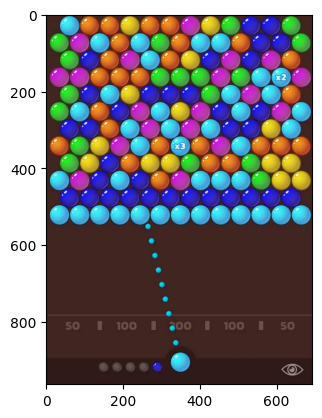

In [95]:
# ----- IMAGENES DE PRUEBA -----
foto = 'burbujas.png'
imagen = cv2.imread(foto)
plt.imshow(imagen,cmap='gray')
filas, columnas,_ = imagen.shape


# https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html
# https://towardsdatascience.com/image-color-segmentation-by-k-means-clustering-algorithm-5792e563f26e
# https://rua.ua.es/dspace/bitstream/10045/17323/3/aristas.pdf
# https://alojamientos.us.es/gtocoma/pid/tema5-1.pdf


Objetivo: Contar el numero de objetos circulares en la imagen y separarlos por clúster

102


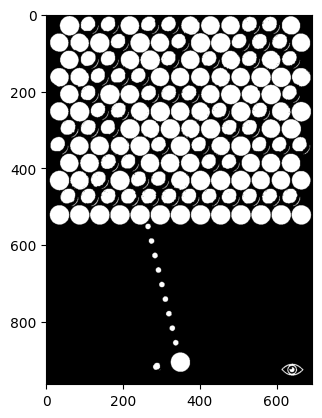

In [96]:
# ----- UMBRALIZACION CON OTSU -----
umbral,imgOtsu = umbralizacionOtsu(foto)
print(umbral)
plt.imshow(imgOtsu,cmap='gray')

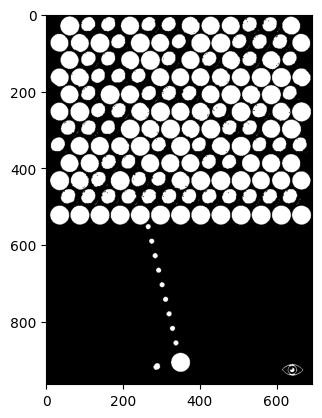

In [97]:
# ----- SE APLICA UNA DILATACION -----
def dilatacion(imagen, tam):
    kernel = np.ones((tam, tam), np.uint8)  # Puedes ajustar el tamaño del kernel según tus necesidades

    erosionada = np.zeros_like(imagen)  # Crea una imagen de ceros del mismo tamaño

    for i in range(1, filas):
        for j in range(1, columnas ):
            # Aplica la operación de erosión
            area = imagen[i - 1:i + 1, j - 1:j + 1]
            erosionada[i, j] = np.min(area)  # El valor mínimo en la vecindadsu, np.ones((7, 7), np.uint8))

    cv2.imwrite('dilatacion.png', erosionada)
    plt.imshow(erosionada,cmap='gray')

    return 

dilatacion(imgOtsu,2)


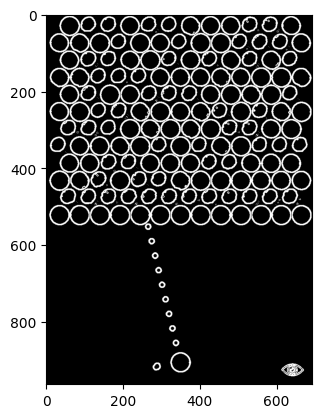

In [98]:
# ----- DETECCION DE BORDES CON CANNY -----
canny = cargarFoto('dilatacion.png', umbral, umbral-10)
imgCanny = Image.fromarray(canny)
cv2.imwrite('canny.png', canny)
plt.imshow(imgCanny)



194
         mediaB      mediaG      mediaR
0    101.946915   85.474892   83.244620
2     60.223854  174.864709  206.456609
11    62.276806  176.721400  208.564379
13    61.773724  176.403312  208.739928
14    61.873936  176.472459  208.650470
..          ...         ...         ...
189  215.864947  119.652504   36.935508
190  216.392308  120.099231   36.887692
191   55.901975  179.192593   52.310617
192  108.642659  132.102863  137.870272
193   97.247511  149.976793  129.989451

[61 rows x 3 columns]


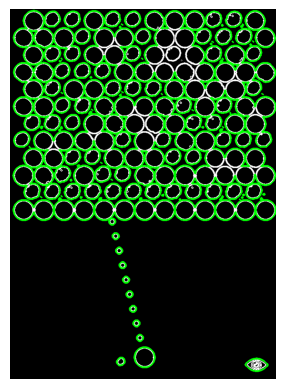

In [99]:
canny = canny.astype(np.uint8)

contornos, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

imgContornos = canny.copy()
imgContornos = cv2.cvtColor(imgContornos, cv2.COLOR_GRAY2BGR)
cv2.drawContours(imgContornos, contornos, -1, (0, 255, 0), 3)
plt.imshow(imgContornos)
plt.axis('off')


print(len(contornos))

finalcontornos = []
tabla_medias = pd.DataFrame()
for i, cont in enumerate(contornos):
    area = int(cv2.contourArea(cont))

    # if area is higher than 3000:
    if area > 1000:
        finalcontornos.append(cont)
        # get mean color of cont:
        filtro = np.zeros_like(imagen[:, :, 0])  # This mask is used to get the mean color of the specific bead (cont), for kmeans
        cv2.drawContours(filtro, [cont], 0, 255, -1)

        mediaB, mediaG, mediaR, _ = cv2.mean(imagen, mask=filtro)
        df = pd.DataFrame({'mediaB': mediaB, 'mediaG': mediaG, 'mediaR': mediaR}, index=[i])
        tabla_medias = pd.concat([tabla_medias, df])


print(tabla_medias)

True

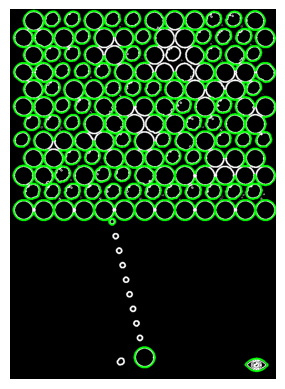

In [100]:
contornos_img_after_filtering = canny.copy()
contornos_img_after_filtering = cv2.cvtColor(contornos_img_after_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contornos_img_after_filtering, tuple(finalcontornos), -1, (0, 255, 0), 3)

plt.imshow(contornos_img_after_filtering)
plt.axis('off')

cv2.imwrite('contornos.png', cv2.hconcat([imgContornos, contornos_img_after_filtering]))


In [101]:
# Extrae los valores de mediaB, mediaG y mediaR
mediaB = tabla_medias['mediaB'].to_numpy()
mediaG = tabla_medias['mediaG'].to_numpy()
mediaR = tabla_medias['mediaR'].to_numpy()

data = np.column_stack((mediaB, mediaG, mediaR))

# Número de clústeres
K = 15

def distancia(punto1, punto2):
    return np.sqrt(np.sum((punto1 - punto2) ** 2))

def puntosCentroidas(datos, centroides):
    asignaciones = np.zeros(len(datos))
    for i, punto in enumerate(datos):
        distancias = [distancia(punto, centroide) for centroide in centroides]
        asignaciones[i] = np.argmin(distancias)
    return asignaciones

def calcular_nuevos_centroides(datos, asignaciones, K):
    nuevos_centroides = []
    for i in range(K):
        puntos_asignados = datos[asignaciones == i]
        nuevo_centroide = np.mean(puntos_asignados, axis=0)
        nuevos_centroides.append(nuevo_centroide)
    return np.array(nuevos_centroides)



c:\Users\urina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\urina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\urina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\urina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

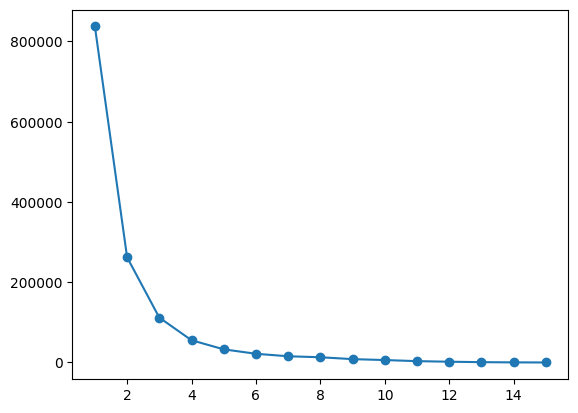

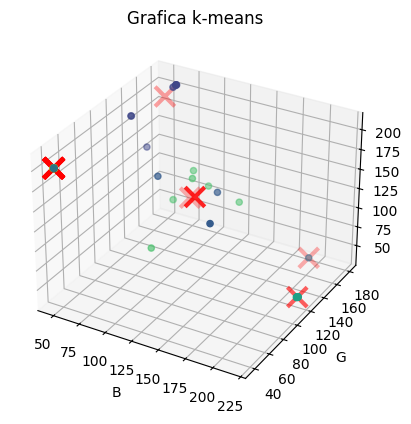

In [102]:
# Inicialización  centroides al azar
centroides = data[np.random.choice(len(data), K, replace=False)]

tolerancia = 1e-4

# Iterar hasta que los centroides converjan
for _ in range(300):  # Límite máximo de iteraciones
    asignaciones = puntosCentroidas(data, centroides)
    nuevos_centroides = calcular_nuevos_centroides(data, asignaciones, K)
    
    # Comprobar la convergencia
    if np.all(np.abs(centroides - nuevos_centroides) < tolerancia):
        break
    
    centroides = nuevos_centroides


#-----------------------------------------------------------------Metodo del codo
X=data
inertia_values = []
#----------------------------------------------------------
for i in range(1, K + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)


plt.plot(range(1, K + 1), inertia_values, marker='o', linestyle='-')
#-----------------------------------------------------------------------------------
# Crear una gráfica 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=asignaciones, cmap='viridis')
ax.scatter(centroides[:, 0], centroides[:, 1], centroides[:, 2], marker='x', s=200, linewidths=3, color='red')
ax.set_xlabel("B")
ax.set_ylabel("G")
ax.set_zlabel("R")
ax.set_title("Grafica k-means")

plt.show()